<a href="https://colab.research.google.com/github/LUCAS-01SANTOS/Projeto-PIBIC-2023/blob/main/spacy_tf_idf_clustering_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clusterização de documentos k-means e vetorização TF-IDF
### Com python | spacy | tf-idf | k-means



> Projeto PIBIC - Lucas Santos
> [GitHub](https://github.com/LUCAS-01SANTOS)




## 1. Setup

### 1.1 Conectando com Drive

In [ ]:
# Conecção com o Drive para gravação.
# Essa parte só será executada caso seja necessário salvar algo do cógigo no Drive.
from google.colab import drive
from google.colab import auth
auth.authenticate_user()
from googleapiclient.discovery import build
drive_service = build('drive', 'v3')
from googleapiclient.http import MediaFileUpload

In [ ]:
# Conecção com o Drive para leitura.
# Essa parte será executada para carregar arquivos do Drive para o código.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 1.2 Instalando bibliotecas

In [ ]:
!pip install -q wordcloud
!pip install -q yellowbrick
!pip install -q spacy
!python -m spacy download pt_core_news_md

### 1.3 Importando bibliotecas

In [ ]:
import os
import numpy as np
import pandas as pd
import spacy
from spacy.lang.pt.stop_words import STOP_WORDS
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer

# Visualização dos gráficos
import matplotlib.pyplot as plt
import plotly.express as px
from yellowbrick.text import UMAPVisualizer, FreqDistVisualizer
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance
from wordcloud import WordCloud

## 2. Preparação do corpus

### 2.1 Carregando dos textos brutos e salvar em DataFrame

In [ ]:
pasta_documentos = "/content/drive/MyDrive/Projeto_PIBIC_Lucas/01_Data/03_Textos das Atividades - tratados"
documentos = []
nomes_arquivos = []

for arquivo in os.listdir(pasta_documentos):
    if arquivo.endswith(".txt"):
        caminho_arquivo = os.path.join(pasta_documentos, arquivo)
        with open(caminho_arquivo, "r", encoding="utf-8") as f:
            texto = f.read()
        documentos.append(texto)
        nomes_arquivos.append(arquivo)

df_documentos = pd.DataFrame({"Nome": nomes_arquivos, "Texto": documentos})

In [ ]:
df_documentos.sort_values(by='Nome')
df_documentos

,Nome,Texto
0,CONSORCIO ALFA DE ADMINISTRACAO.txt,/ 7.1 - Descrição - atividades emissor/control...
1,CONSERVAS ODERICH.txt,/ 7.1 - Descrição - atividades emissor/control...
2,CONSTRUTORA ADOLPHO LINDENBERG.txt,/ 7.1 - Descrição - atividades emissor/control...
3,CONST LIX DA CUNHA SA.txt,/ 7.1 - Descrição - atividades emissor/control...
4,CONSTRUTORA SULTEPA.txt,/ 7.1 - Descrição - atividades emissor/control...
...,...,...
545,autometal.txt,/ 7.1 - Descrição - atividades emissor/control...
546,autopista fe.txt,/ 7.1 - Descrição - atividades emissor/control...
547,autovias.txt,/ 7.1 - Descrição - atividades emissor/control...
548,azevedo.txt,/ 7.1 - Descrição - atividades emissor/control...


In [ ]:
df_documentos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550 entries, 0 to 549
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Nome    550 non-null    object
 1   Texto   550 non-null    object
dtypes: object(2)
memory usage: 8.7+ KB


### 2.2 Pré-processamento de textos

In [ ]:
# Carregar o modelo do Spacy para o idioma português
nlp = spacy.load('pt_core_news_md')

# Etapas de pipeline do modelo baixado
# ['tok2vec', 'morphologizer', 'parser', 'lemmatizer', 'attribute_ruler', 'ner']

[arquivo de stopwords personalizadas](https://drive.google.com/file/d/1GcqN8As04ZnJ7Mwjz5FjL4n6YdfJto7v/view?usp=sharing)

In [ ]:
# Carregar lista de stop words personalizada.
custom_stopwords = ['/content/minhas_stopwords.txt']
with open('minhas_stopwords.txt', 'r', encoding='utf-8') as file:
    custom_stopwords = file.read().splitlines()

# Converter a lista em um conjunto
custom_stopwords = set(custom_stopwords)

# Combinar as stopwords existentes com as stopwords personalizadas
stopwords = STOP_WORDS.union(custom_stopwords)

In [ ]:
# Função para pré-processar um texto
def preprocess_text(text):
    # Tokenização
    doc = nlp(text)
    tokens = [token.lemma_.lower() for token in doc if not token.is_punct]

    # Remoção de stopwords
    tokens = [token for token in tokens if token not in stopwords]

    # Normalização de texto
    tokens = [token.lower() for token in tokens]

    return tokens

In [ ]:
# Passo 2: Pré-processamento dos textos
preprocessed_documents = []
for document in df_documentos["Texto"]:
    tokens = preprocess_text(document)
    preprocessed_documents.append(' '.join(tokens))

In [ ]:
df_documentos["Tokens_Preprocessados"] = df_documentos["Texto"].apply(preprocess_text)
df_documentos["Texto_Preprocessado"] = df_documentos["Tokens_Preprocessados"].str.join(" ")

In [ ]:
df_documentos = df_documentos.sort_values(by='Nome')

In [ ]:
print(df_documentos.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 550 entries, 507 to 549
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Nome                   550 non-null    object
 1   Texto                  550 non-null    object
 2   Tokens_Preprocessados  550 non-null    object
 3   Texto_Preprocessado    550 non-null    object
dtypes: object(4)
memory usage: 21.5+ KB
None


In [ ]:
# Contando linhas em branco na coluna "Tokens_Preprocessados"
blank_lines_tokens = df_documentos["Tokens_Preprocessados"].apply(lambda x: len(x) == 0).sum()
print(f"Número de linhas em branco na coluna 'Tokens_Preprocessados': {blank_lines_tokens}")

# Contando linhas em branco na coluna "Texto_Preprocessado"
blank_lines_texto = df_documentos["Texto_Preprocessado"].apply(lambda x: len(x.strip()) == 0).sum()
print(f"Número de linhas em branco na coluna 'Texto_Preprocessado': {blank_lines_texto}")


Número de linhas em branco na coluna 'Tokens_Preprocessados': 0
Número de linhas em branco na coluna 'Texto_Preprocessado': 0


In [ ]:
# Salvar o novo DataFrame como CSV
df_documentos.to_csv("/content/drive/MyDrive/Projeto_PIBIC_Lucas/01_Data/corpus_preprocessado_v2.csv", index=False)

### 2.3 Carremento do curpus pré-processado

In [ ]:
df_corpus = pd.read_csv("/content/drive/MyDrive/Projeto_PIBIC_Lucas/01_Data/corpus_preprocessado_v2.csv")

In [ ]:
df_corpus

,Nome,Texto,Tokens_Preprocessados,Texto_Preprocessado
0,521 particip.txt,/ 7.1 - Descrição - atividades emissor/control...,"['7.1', 'descrição', 'atividade', 'emissor', '...",7.1 descrição atividade emissor controlar \n 7...
1,524 particip.txt,/ 7.1 - Descrição - atividades emissor/control...,"['7.1', 'descrição', 'atividade', 'emissor', '...",7.1 descrição atividade emissor controlar \n 7...
2,B3.txt,/ 7.1 - Descrição - atividades emissor/control...,"['7.1', 'descrição', 'atividade', 'emissor', '...",7.1 descrição atividade emissor controlar \n b...
3,BAHEMA.txt,/ 7.1 - Descrição - atividades emissor/control...,"['7.1', 'descrição', 'atividade', 'emissor', '...",7.1 descrição atividade emissor controlar \n 7...
4,BANCO PAN.txt,/ 7.1 - Descrição - atividades emissor/control...,"['7.1', 'descrição', 'atividade', 'emissor', '...",7.1 descrição atividade emissor controlar \n 7...
...,...,...,...,...
545,autometal.txt,/ 7.1 - Descrição - atividades emissor/control...,"['7.1', 'descrição', 'atividade', 'emissor', '...",7.1 descrição atividade emissor controlar \n a...
546,autopista fe.txt,/ 7.1 - Descrição - atividades emissor/control...,"['7.1', 'descrição', 'atividade', 'emissor', '...",7.1 descrição atividade emissor controlar \n a...
547,autovias.txt,/ 7.1 - Descrição - atividades emissor/control...,"['7.1', 'descrição', 'atividade', 'emissor', '...",7.1 descrição atividade emissor controlar \n d...
548,azevedo.txt,/ 7.1 - Descrição - atividades emissor/control...,"['7.1', 'descrição', 'atividade', 'emissor', '...",7.1 descrição atividade emissor controlar \n 7...


### 2.4 Visualização do corpus como wordcloud

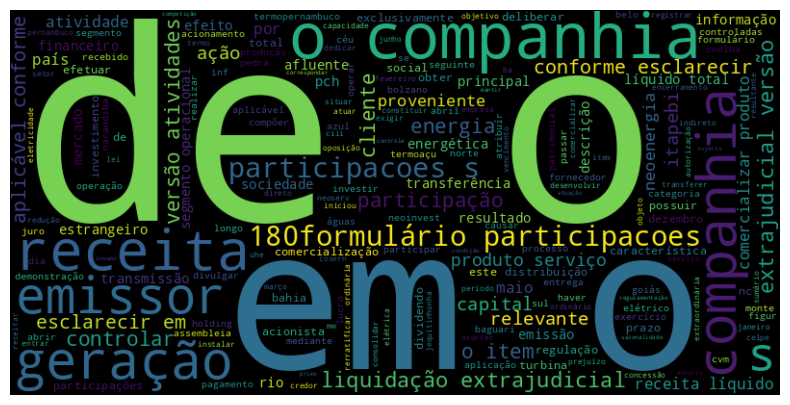

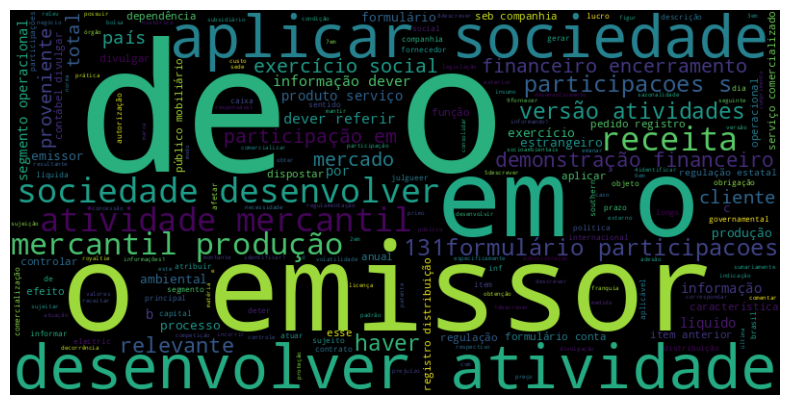

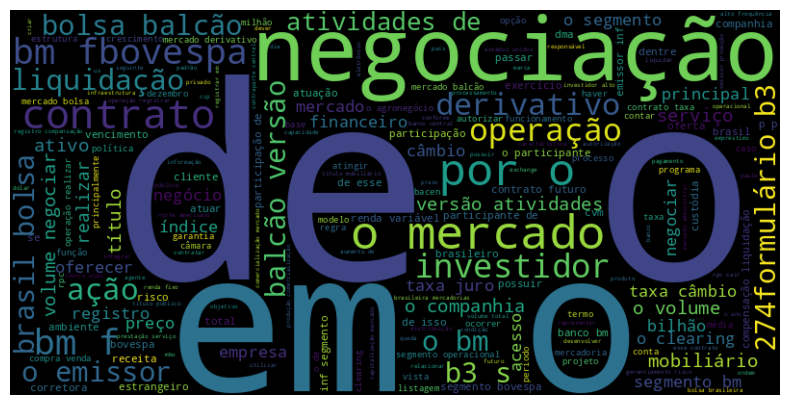

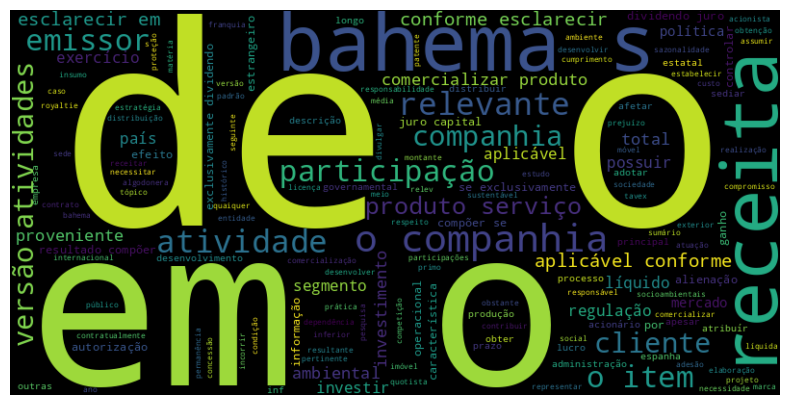

In [ ]:
# Função para gerar WordClouds
def gerar_wordcloud(texto):
    wordcloud = WordCloud(width=800, height=400, background_color="black").generate(texto)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

contador = 0
for texto in df_corpus["Texto_Preprocessado"]:
    gerar_wordcloud(texto)
    contador += 1
    if contador == 4:
        break

## 3. Vetorização do texto

## 3.1 Vetorização do texto

In [ ]:
vectorizer = TfidfVectorizer()
vetor_texto = vectorizer.fit_transform(df_corpus["Texto_Preprocessado"])

# Imprimir o resultado da vetorização
print("Vetor TF-IDF:")
print(vetor_texto)

Vetor TF-IDF:
  (0, 3479)	0.012302763579945598
  (0, 16641)	0.011138493111102016
  (0, 20856)	0.009443691297774854
  (0, 38884)	0.006235268170088313
  (0, 3463)	0.011967409185871653
  (0, 22363)	0.01625145467453896
  (0, 21819)	0.021921223120660475
  (0, 28817)	0.013585991615020977
  (0, 42109)	0.0063611988586890975
  (0, 35567)	0.006257967585857136
  (0, 3442)	0.012240369403205031
  (0, 31604)	0.007941900231057106
  (0, 44167)	0.010910748596269572
  (0, 31834)	0.0073398000812538175
  (0, 25977)	0.01566872811723832
  (0, 3421)	0.012117507536359814
  (0, 20378)	0.02494107268035325
  (0, 35810)	0.022391394973381423
  (0, 41036)	0.008645606910712577
  (0, 7842)	0.0192820272287007
  (0, 32595)	0.022686172861869237
  (0, 34310)	0.033902845652851656
  (0, 21041)	0.006212654900317063
  (0, 38200)	0.006246607068720585
  (0, 3379)	0.010456768801531817
  :	:
  (549, 7741)	0.12369579471692148
  (549, 46501)	0.059051588951272896
  (549, 1392)	0.05991526029159153
  (549, 44606)	0.006187865571946376

### 3.2 Visualização da Frequência dos termos nos documentos vetorizados

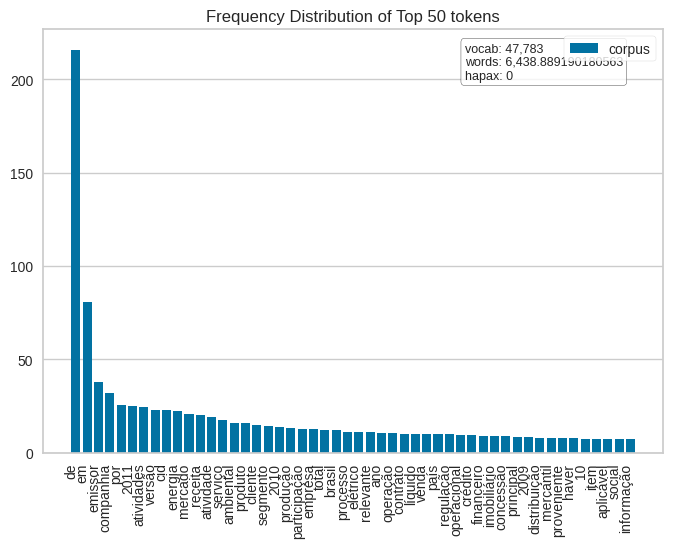

<Axes: title={'center': 'Frequency Distribution of Top 50 tokens'}>

In [ ]:
freqdist_visualizer = FreqDistVisualizer(features=vectorizer.get_feature_names_out(), orient='v')
freqdist_visualizer.fit(vetor_texto)
freqdist_visualizer.show()

## 4. Redução de dimensionalidade

In [ ]:
# método TruncatedSVD
svd = TruncatedSVD(n_components=2)
redução_svd = svd.fit_transform(vetor_texto)

In [ ]:
# método PCA
pca = PCA(n_components=2)
redução_pca = pca.fit_transform(vetor_texto.toarray())

## 5. Escolhendo o número adequado de clusters

### 5.1 Visualização do número ideal de clusters (k-elbow plot)

**[Método Cotovelo](https://www.scikit-yb.org/en/latest/api/cluster/elbow.html):**
O implementa o método "cotovelo" para ajudar os cientistas de dados a selecionar o número ideal de clusters, ajustando o modelo com uma faixa de valores para . Se o gráfico de linhas se assemelha a um braço, então o "cotovelo" (o ponto de inflexão na curva) é uma boa indicação de que o modelo subjacente se encaixa melhor nesse ponto. No visualizador o "cotovelo" será anotado com uma linha tracejada. Também exibe a quantidade de tempo para treinar o modelo de clustering como uma linha verde tracejada

O modelo se ajusta a um intervalo de valores de 5 a 20 em um conjunto de dados bidimensional de amostra com 10 clusters aleatórios de pontos.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

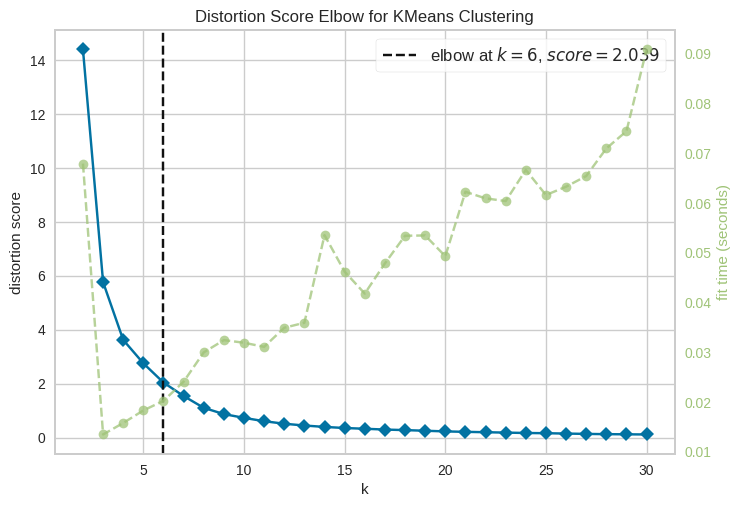

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
# Elbow plot com TruncatedSVD
model = KMeans()
elbow_visualizer = KElbowVisualizer(model, k=(2,31))
elbow_visualizer.fit(vetores_reduzidos)
elbow_visualizer.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

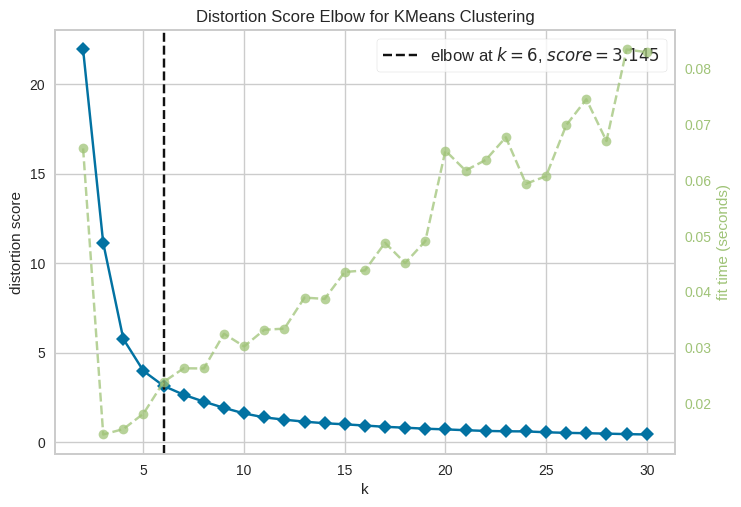

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
# Elbow plot com pca
model = KMeans()
elbow_visualizer = KElbowVisualizer(model, k=(2,31))
elbow_visualizer.fit(redução_pca)
elbow_visualizer.show()

### 5.2 Visualização da silhueta dos clusters

**[Coeficiênte de Silhueta](https://www.scikit-yb.org/en/latest/api/cluster/silhouette.html)**: O Silhouette Visualizer exibe o coeficiente de silhueta para cada amostra em uma base por conglomerado, visualizando quais clusters são densos e quais não são. Isso é particularmente útil para determinar o desequilíbrio do cluster ou para selecionar um valor para comparando vários visualizadores.

A linha tracejada no gráfico representa a pontuação média da silhueta.

A pontuação da silhueta varia de -1 a 1.

Uma pontuação de silhueta de 1 indica que os aglomerados são muito densos e bem separados. Uma pontuação de 0 significa que os clusters estão sobrepostos. Uma pontuação inferior a 0 sugere que os pontos de dados atribuídos aos clusters podem ser classificados incorretamente


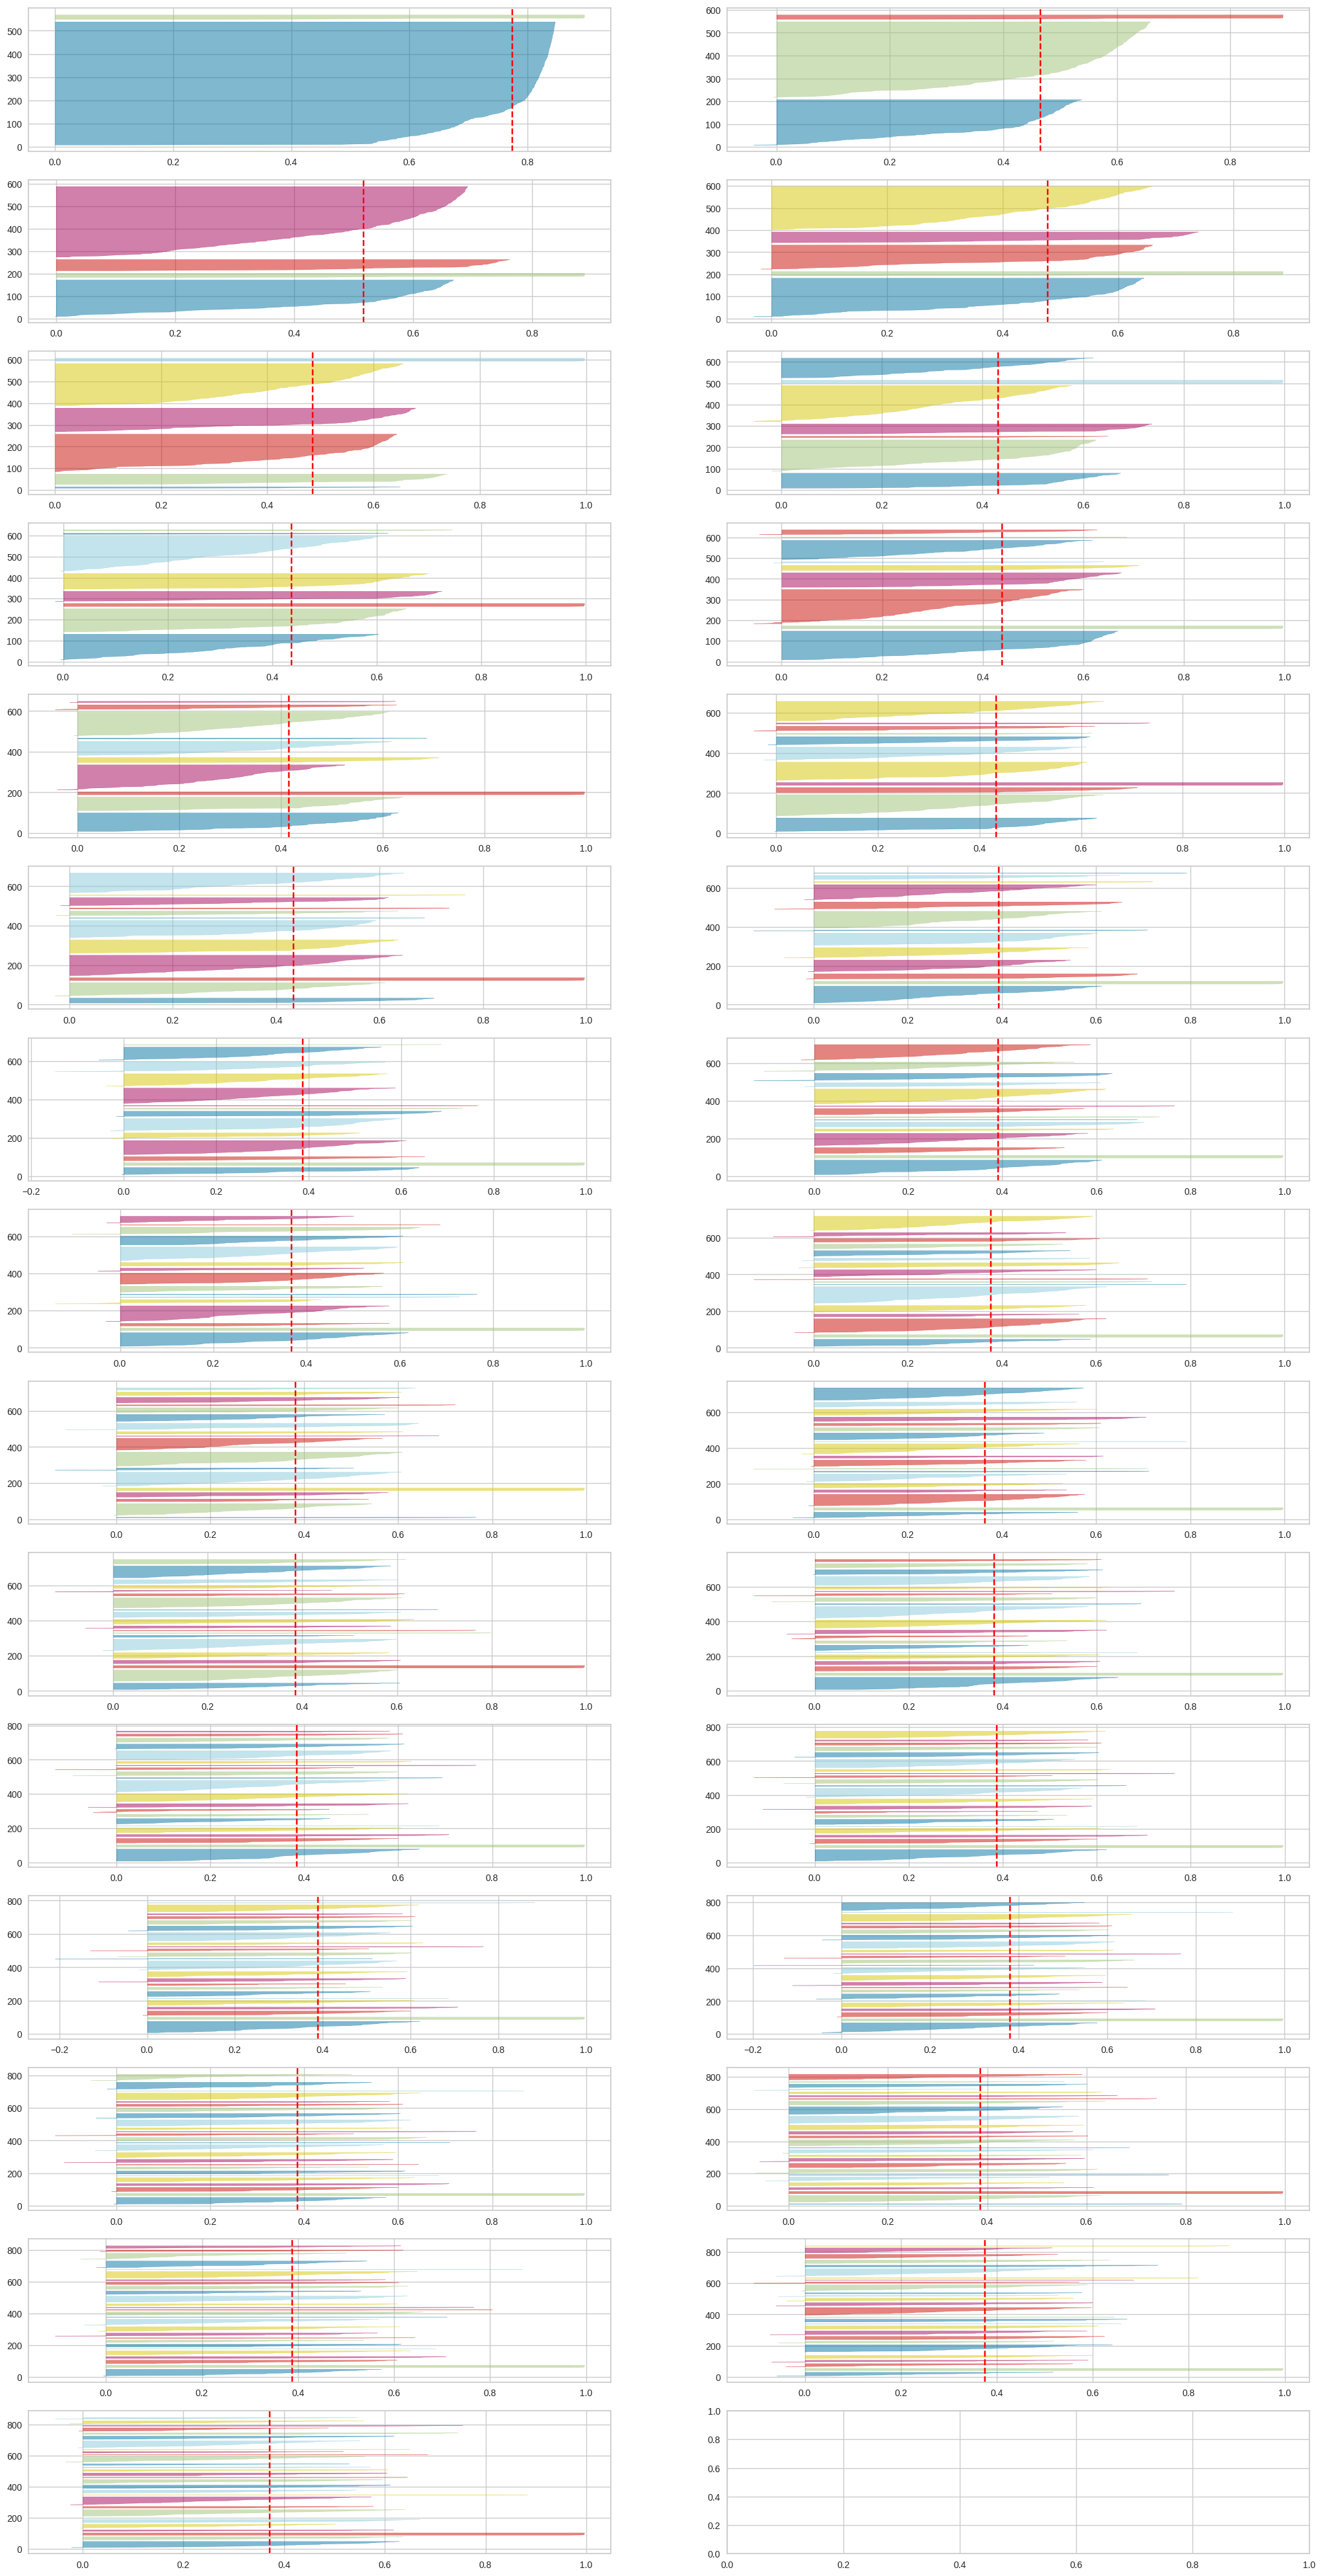

In [ ]:
'''
Este código percorre o intervalo de número de clusters (2 a 20),
a cada iteração, ele cria uma instância do algoritmo KMeans com o número de clusters como i e, em seguida, divide i por 2 e obtém o quociente e o restante.
Em seguida, ele cria uma instância do SilhouetteVisualizer com a instância KMeans e define a cor como yellowbrick e o parâmetro ax é definido como ax[qou-1][rem].
Finalmente, ajusta o visualizador com os embeddings.
'''
# Create a figure and set of subplots with 15 rows and 2 columns.
fig, ax = plt.subplots(nrows=15, ncols=2, figsize=(25, 50))

# Iterate through the range of number of clusters (2 to 30)
for i in range(2, 31):
    # Create a KMeans instance with the number of clusters as i
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=11)
    # Subtract 2 from i to start indexing from 0
    idx = i - 2
    # Divide idx by 2 and get the quotient and remainder
    quo, rem = divmod(idx, 2)

    # Create an instance of SilhouetteVisualizer with the KMeans instance and set the color to yellowbrick
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[quo][rem])
    # Fit the visualizer with the embeddings
    visualizer.fit(redução_pca)


Nossos critérios para selecionar a melhor visualização de cluster são os seguintes:

- Presença de mais aglomerados com pontuações de silhueta acima da média (conforme indicado pela linha tracejada)
- Menos flutuação no tamanho dos gráficos de silhueta (indicando aglomerados mais uniformes)
- Menos pontos negativos, que representam possíveis agrupamentos incorretos.

Para nos auxiliar ainda mais na seleção do melhor valor de k, utilizaremos a pontuação Silhouette do sklearn para calcular as pontuações para cada cluster.

In [ ]:
# Criar uma lista de possíveis números de clusters para tentar
num_clusters = list(range(2, 31))

# Calcule as pontuações de silhueta para cada número de clusters
silhouette_scores = []
for k in num_clusters:
    # executar o agrupamento para cada k
    kmeans = KMeans(n_clusters=k,n_init=10)
    kmeans.fit(redução_pca)
    labels = kmeans.predict(redução_pca)
    # Cálculo da pontuação mais baixa
    sil_score=silhouette_score(redução_pca,labels)
    print("cluster:",k,  "score -> ",  sil_score)
    silhouette_scores.append(sil_score)


# exibindo o número ideal de
optimal_num_clusters = num_clusters[silhouette_scores.index(max(silhouette_scores))]
print("O s-score mais alto dos k-clusters: " , optimal_num_clusters)


cluster: 2 score ->  0.7739955521718159
cluster: 3 score ->  0.46482418000069764
cluster: 4 score ->  0.5168611795237512
cluster: 5 score ->  0.47779701542867253
cluster: 6 score ->  0.4857626151753087
cluster: 7 score ->  0.4275026402778912
cluster: 8 score ->  0.4270504685505189
cluster: 9 score ->  0.433217265207596
cluster: 10 score ->  0.41536127754186136
cluster: 11 score ->  0.4328048662204246
cluster: 12 score ->  0.43497155911563545
cluster: 13 score ->  0.4041373355541201
cluster: 14 score ->  0.3875259582071255
cluster: 15 score ->  0.3756341471288016
cluster: 16 score ->  0.38713794609981267
cluster: 17 score ->  0.39055760307546405
cluster: 18 score ->  0.3630063686099506
cluster: 19 score ->  0.36225577899884936
cluster: 20 score ->  0.37246027366808354
cluster: 21 score ->  0.38615062959424107
cluster: 22 score ->  0.3799502515524531
cluster: 23 score ->  0.3840691887287648
cluster: 24 score ->  0.3805521197469775
cluster: 25 score ->  0.3804568644169717
cluster: 26 scor

## 6. Agrupamento dos textos com k-means

### 6.1 Agrupamento com k-means com TruncatedSVD

In [ ]:
kmeans_svd = KMeans(n_clusters=27, max_iter=100, n_init=5)
rotulos_clusters_svd = kmeans_svd.fit_predict(redução_svd)

### 6.2 Agrupamento com k-means com PCA

In [ ]:
kmeans_pca = KMeans(n_clusters=27, max_iter=100, n_init=5)
rotulos_clusters_pca = kmeans_pca.fit_predict(redução_pca)

## 7. Visualizações dos clusters

### 7.2 Visualização da distância dos clusters

In [ ]:
# Obtenção dos centros do k-means
centros_1 = kmeans_svd.cluster_centers_

# Conversão dos dados para DataFrame
df_clusters_SVD = pd.DataFrame({"X": redução_svd[:, 0], "Y": redução_svd[:, 1], "Cluster": rotulos_clusters_svd, "Nome": df_corpus["Nome"]})

# Plot do gráfico de dispersão com destaque nos centros do k-means
fig = px.scatter(df_clusters_SVD, x="X", y="Y", color="Cluster", hover_data=["Nome"], title="Gráfico de Dispersão dos Clusters (com redução TruncatedSVD)")
fig.add_scatter(x=centros_1[:, 0], y=centros_1[:, 1], mode="markers", marker=dict(size=10, color="black", symbol="x"), name="Centros do K-means")
fig.update_layout(
    width=1000,  # Define a largura da figura
    height=700  # Define a altura da figura
)
fig.show()

df_clusters_SVD = df_clusters_SVD.sort_values(by='Cluster')
df_clusters_SVD

,X,Y,Cluster,Nome
320,0.403253,0.034956,0,M&G POLIÉSTER SA.txt
479,0.413632,-0.010427,0,TAM S.A..txt
27,0.413715,-0.016457,0,AMPLA INVEST.txt
34,0.417317,-0.017767,0,ATOMPAR.txt
486,0.415878,-0.019738,0,TECNOSOLO ENGENHARIA S.A.txt
...,...,...,...,...
519,0.434014,-0.010764,26,VALID.txt
86,0.453510,-0.021251,26,BRZ INVEST.txt
493,0.438398,0.001744,26,"TELEFÓNICA, S.A..txt"
171,0.439373,-0.014929,26,DEXXOS PARTICIPAÇÕES S.A..txt


In [ ]:
# Obtenção dos centros do k-means
centros_2 = kmeans_pca.cluster_centers_

# Conversão dos dados para DataFrame
df_clusters_PCA = pd.DataFrame({"X": redução_pca[:, 0], "Y": redução_pca[:, 1], "Cluster": rotulos_clusters_pca, "Nome": df_corpus["Nome"]})

# Defina uma paleta de cores mais agradável
color_palette = px.colors.qualitative.Set1

# Crie o gráfico
fig = px.scatter(df_clusters_PCA,
                 x="X",
                 y="Y",
                 color="Cluster",
                 hover_data=["Nome"],
                 title="Gráfico de Dispersão dos Clusters (com redução PCA)",
                 color_discrete_sequence=color_palette)

# Adicione marcadores para os centros do K-means
fig.add_scatter(x=centros_2[:, 0], y=centros_2[:, 1], mode="markers", marker=dict(size=10, color="black", symbol="x"), name="Centros do K-means")

# Atualize o layout do gráfico
fig.update_layout(
    template="plotly_white",  # Fundo branco
    width=1000,
    height=700,
    font=dict(family="Arial", size=12),  # Fonte legível
    legend=dict(title="Cluster"),  # Título da legenda
    xaxis_title="Componente X",
    yaxis_title="Componente Y"
)

# Exiba o gráfico
fig.show()

df_clusters_PCA = df_clusters_PCA.sort_values(by='Cluster')
df_clusters_PCA

,X,Y,Cluster,Nome
59,0.944793,0.486034,0,CAPITALPART.txt
413,0.929971,0.488341,0,SCHULZ.txt
36,0.942345,0.484926,0,BRAZILIAN SC.txt
37,0.944818,0.486183,0,BRB BANCO.txt
456,0.945047,0.486179,0,TELINVEST SA.txt
...,...,...,...,...
329,0.277015,-0.156523,26,NORDON INDUSTRIAS METALURGICAS.txt
303,0.247350,-0.145055,26,METALURGICA RIOSULENSE S.A..txt
374,0.256765,-0.143716,26,PRÓ METALURGIA SA.txt
437,0.234917,-0.132778,26,TAIPE TRANCOSO EMPREENDIMENTOS SA.txt


In [ ]:
# Obtenção dos centros do k-means
centros_2 = kmeans_pca.cluster_centers_

# Conversão dos dados para DataFrame
df_clusters_PCA = pd.DataFrame({"X": redução_pca[:, 0], "Y": redução_pca[:, 1], "Cluster": rotulos_clusters_pca, "Nome": df_corpus["Nome"]})

# Plot do gráfico de dispersão com destaque nos centros do k-means
fig = px.scatter(df_clusters_PCA,
                 x="X",
                 y="Y",
                 template="plotly_dark",
                 color="Cluster",
                 hover_data=["Nome"],
                 title="Gráfico de Dispersão dos Clusters (com resução PCA)")
fig.add_scatter(x=centros_2[:, 0], y=centros_2[:, 1], mode="markers", marker=dict(size=10, color="white", symbol="x"), name="Centros do K-means")
fig.update_layout(
    width=1000,  # Define a largura da figura
    height=700  # Define a altura da figura
)
fig.show()

df_clusters_PCA = df_clusters_PCA.sort_values(by='Cluster')
df_clusters_PCA

,X,Y,Cluster,Nome
59,0.944793,0.486034,0,CAPITALPART.txt
413,0.929971,0.488341,0,SCHULZ.txt
36,0.942345,0.484926,0,BRAZILIAN SC.txt
37,0.944818,0.486183,0,BRB BANCO.txt
456,0.945047,0.486179,0,TELINVEST SA.txt
...,...,...,...,...
329,0.277015,-0.156523,26,NORDON INDUSTRIAS METALURGICAS.txt
303,0.247350,-0.145055,26,METALURGICA RIOSULENSE S.A..txt
374,0.256765,-0.143716,26,PRÓ METALURGIA SA.txt
437,0.234917,-0.132778,26,TAIPE TRANCOSO EMPREENDIMENTOS SA.txt


### 7.3 Heatmap dos clusters

In [ ]:
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity

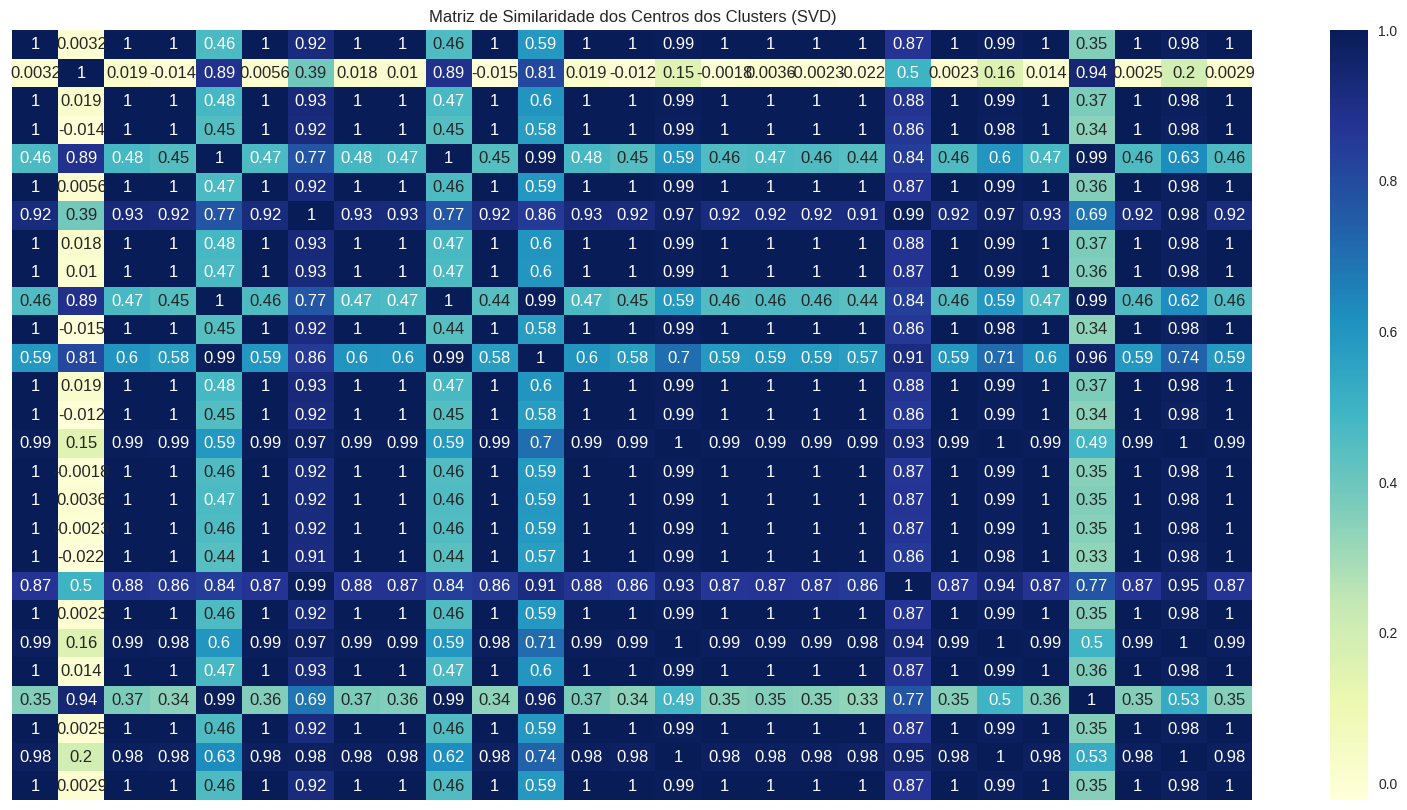

In [ ]:
# Calcular a matriz de similaridade dos centros dos clusters para o SVD
matriz_similaridade_svd = cosine_similarity(centros_1)

# Plotar o heatmap para a matriz de similaridade
plt.figure(figsize=(20, 10))
sns.heatmap(matriz_similaridade_svd, annot=True, cmap="YlGnBu", xticklabels=False, yticklabels=False)
plt.title("Matriz de Similaridade dos Centros dos Clusters (SVD)")
plt.show()

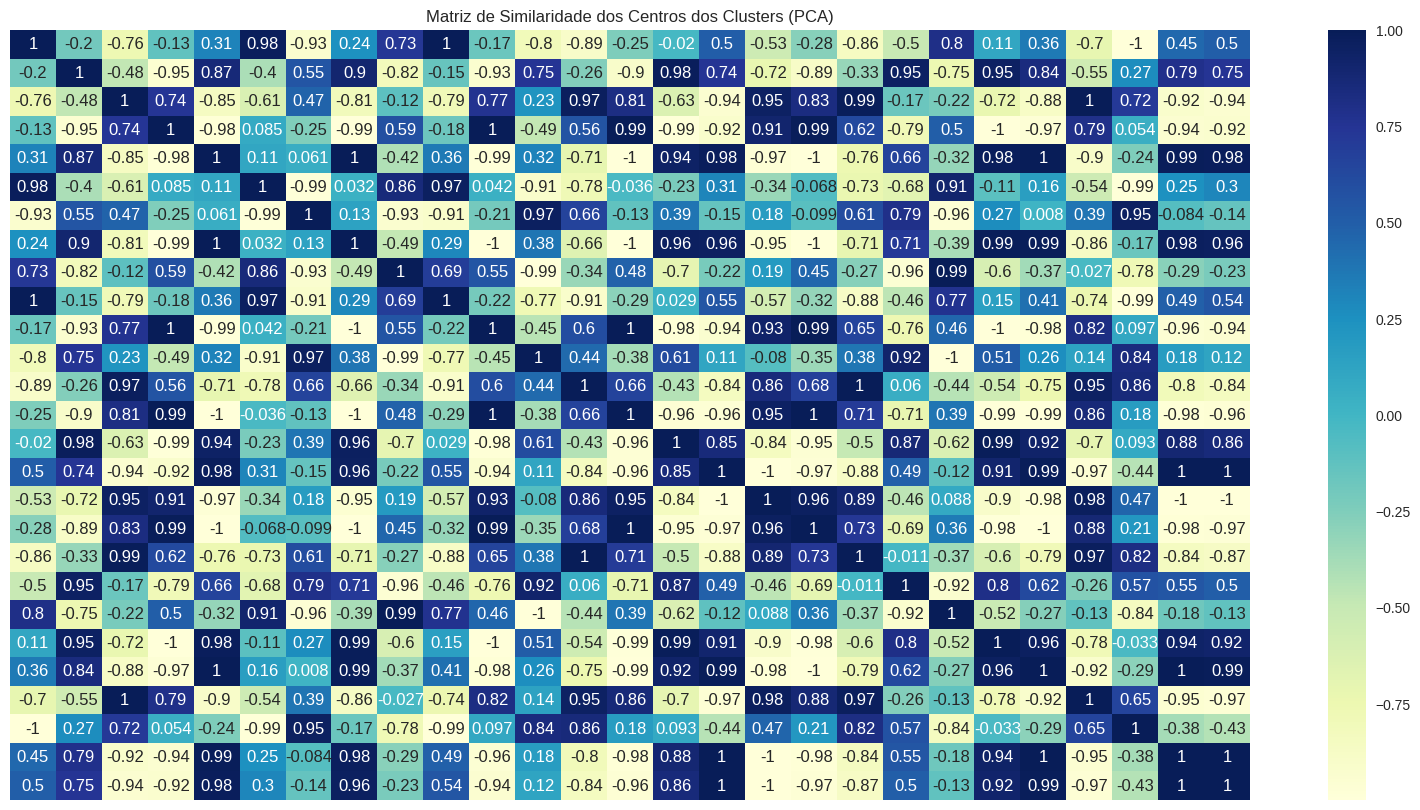

In [ ]:
# Calcular a matriz de similaridade dos centros dos clusters para o PCA
matriz_similaridade_pca = cosine_similarity(centros_2)

# Plotar o heatmap para a matriz de similaridade
plt.figure(figsize=(20, 10))
sns.heatmap(matriz_similaridade_pca, annot=True, cmap="YlGnBu", xticklabels=False, yticklabels=False)
plt.title("Matriz de Similaridade dos Centros dos Clusters (PCA)")
plt.show()